<a href="https://colab.research.google.com/github/susumu2357/US-patent-analysis/blob/master/colab/Decision_boundaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np

In [0]:
filename = "USE_grants_for_3000+3000_concat_feature.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/results/{filename} ./

with gzip.open(filename, 'rb') as f:
  grants_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/results/USE_grants_for_3000+3000_concat_feature.pkl.gz...
- [1 files][ 26.7 MiB/ 26.7 MiB]                                                
Operation completed over 1 objects/26.7 MiB.                                     


In [0]:
filename = "USE_train_app_3000_concat_feature.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/results/{filename} ./

with gzip.open(filename, 'rb') as f:
  train_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/results/USE_train_app_3000_concat_feature.pkl.gz...
/ [1 files][ 12.4 MiB/ 12.4 MiB]                                                
Operation completed over 1 objects/12.4 MiB.                                     


In [0]:
filename = "USE_test_app_3000_concat_feature.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/results/{filename} ./

with gzip.open(filename, 'rb') as f:
  test_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/results/USE_test_app_3000_concat_feature.pkl.gz...
/ [1 files][ 12.4 MiB/ 12.4 MiB]                                                
Operation completed over 1 objects/12.4 MiB.                                     


In [0]:
!gsutil cp gs://mlstudy-phys/data/citations_info_3000+3000.df.gz ./citations_info_3000+3000.df.gz
!gsutil cp gs://mlstudy-phys/data/grants_for_3000+3000.df.gz ./grants_for_3000+3000.df.gz
!gsutil cp gs://mlstudy-phys/data/testset_app_3000.df.gz ./testset_app_3000.df.gz
!gsutil cp gs://mlstudy-phys/data/training_app_3000.df.gz ./training_app_3000.df.gz  
  
citations_info = pd.read_pickle("./citations_info_3000+3000.df.gz")
grants = pd.read_pickle("./grants_for_3000+3000.df.gz")
testset_app_3000 = pd.read_pickle("./testset_app_3000.df.gz")
training_app_3000 = pd.read_pickle("./training_app_3000.df.gz")

Copying gs://mlstudy-phys/data/citations_info_3000+3000.df.gz...
/ [1 files][506.5 KiB/506.5 KiB]                                                
Operation completed over 1 objects/506.5 KiB.                                    
Copying gs://mlstudy-phys/data/grants_for_3000+3000.df.gz...
\ [1 files][129.4 MiB/129.4 MiB]                                                
Operation completed over 1 objects/129.4 MiB.                                    
Copying gs://mlstudy-phys/data/testset_app_3000.df.gz...
- [1 files][ 45.5 MiB/ 45.5 MiB]                                                
Operation completed over 1 objects/45.5 MiB.                                     
Copying gs://mlstudy-phys/data/training_app_3000.df.gz...
\ [1 files][ 45.0 MiB/ 45.0 MiB]                                                
Operation completed over 1 objects/45.0 MiB.                                     


In [0]:
import re
CLAIM_PAT = re.compile(r'<claims[^>]*>(.*)</claims>',re.MULTILINE|re.DOTALL)
TAG_PAT = re.compile(r"<.*?>")
LB_PAT = re.compile(r'[\t\n\r\f\v][" "]*')
CANCELED_PAT = re.compile(r'[0-9]+.*\. \(canceled\)[" "]')
NUM_PAT = re.compile(r'[" "]?[0-9]+[" "]?\.[" "]?')

def whole_xml_to_claim_xml(whole):
    mat = CLAIM_PAT.search(whole)
    return mat.group(1)
def whole_xml_to_claim(whole):
    return TAG_PAT.sub(' ', whole_xml_to_claim_xml(whole))

def remove_linebreak_from_claim(claim):
    '''
    Remove line break symbol "\n" with space(s).
    '''
    return LB_PAT.sub('', claim)

def remove_canceled_claim(claim):
    return CANCELED_PAT.sub('', claim)
  
def remove_claim_numbers(claim):
    return NUM_PAT.sub('', claim)  

In [0]:
training_app_3000["claim"] = training_app_3000["xml"].map(whole_xml_to_claim).map(remove_canceled_claim).map(remove_claim_numbers).map(remove_linebreak_from_claim)
testset_app_3000["claim"] = testset_app_3000["xml"].map(whole_xml_to_claim).map(remove_canceled_claim).map(remove_claim_numbers).map(remove_linebreak_from_claim)
grants["claim"] = grants["xml"].map(whole_xml_to_claim).map(remove_canceled_claim).map(remove_claim_numbers).map(remove_linebreak_from_claim)

In [0]:
train_data_for_bert = pd.merge(training_app_3000, citations_info, on='app_id')[['app_id', 'claim', 'parsed']]
dev_data_for_bert = pd.merge(testset_app_3000, citations_info, on='app_id')[['app_id', 'claim', 'parsed']]

In [0]:
train_data_for_bert['label'] = 1
dev_data_for_bert['label'] = 1

In [0]:
train_data_for_bert = train_data_for_bert.merge(grants, how='inner', on='parsed')
train_data_for_bert = train_data_for_bert.drop("xml", axis=1)

dev_data_for_bert = dev_data_for_bert.merge(grants, how='inner', on='parsed')
dev_data_for_bert = dev_data_for_bert.drop("xml", axis=1)

In [0]:
def pick_up_uncited_grants(df, app_id, n=1, random_state=23):
    '''
    Randomly pick up uncited grant pair to a given app_id for generating negative samples.
    '''
    n_rows = df[ df['app_id'] != app_id ].sample(n=n, random_state=random_state)
    
    return [n_rows['parsed'].values[0], 0 ,n_rows['claim_y'].values[0]]

In [0]:
seed = 23

train_non_cited_data = pd.DataFrame([
    [app_id, claimx] + pick_up_uncited_grants(train_data_for_bert, app_id, random_state=seed+idx)
    for idx, (app_id, claimx)
    in enumerate(zip(train_data_for_bert['app_id'], train_data_for_bert['claim_x']))
])

train_non_cited_data.columns = train_data_for_bert.columns

train_non_cited_data.head()

,app_id,claim_x,parsed,label,claim_y
0,12130785,A system for differentiating noise from an arr...,7848141,0,A multi-level cell copyback program method in ...
1,12652424,A method of allocating resources in a data war...,7353145,0,A computer implemented method for correcting a...
2,12652424,A method of allocating resources in a data war...,6928488,0,A serialization and deserialization architectu...
3,12214532,A controlling method of a media processing app...,7287122,0,A method of managing a cache structure of a mu...
4,14204411,An electronic percussion instrument comprising...,7058343,0,A non-marking media consumable material for us...


In [0]:
seed = 23

dev_non_cited_data = pd.DataFrame([
    [app_id, claimx] + pick_up_uncited_grants(dev_data_for_bert, app_id, random_state=seed+idx)
    for idx, (app_id, claimx)
    in enumerate(zip(dev_data_for_bert['app_id'], dev_data_for_bert['claim_x']))
])

dev_non_cited_data.columns = dev_data_for_bert.columns

dev_non_cited_data.head()

,app_id,claim_x,parsed,label,claim_y
0,12211548,A method for ranking an entity against a group...,6989640,0,An actuator driving device of a working machin...
1,12765236,A dental composition comprising:(1) at least o...,6969674,0,A method for making a fine pitch flip chip sub...
2,12827269,"A vehicle, comprising:a chassis; a platform su...",8012334,0,A composition comprising one or more sources o...
3,14436491,A conjugate comprising a GM-CSF polypeptide an...,7523553,0,A method of manufacturing an ink jet recording...
4,13633425,"A method for manufacturing a stack package, co...",6901791,0,A method for diagnosing a fuel supply system o...


In [0]:
train_data_for_bert = pd.concat([train_data_for_bert, train_non_cited_data]).reset_index(drop=True)
dev_data_for_bert = pd.concat([dev_data_for_bert, dev_non_cited_data]).reset_index(drop=True)

In [0]:
train_data_for_bert = train_data_for_bert.sample(frac=1, random_state=seed).reset_index(drop=True)
dev_data_for_bert = dev_data_for_bert.sample(frac=1, random_state=seed).reset_index(drop=True)

In [0]:
train_data_for_bert.head()

,app_id,claim_x,parsed,label,claim_y
0,15116396,Ringed tubular sheath comprising:two internal ...,7706961,0,"A method of controlling a diesel engine, compr..."
1,12312598,An exhaust purification system of an internal ...,7150145,1,A method for controlling dosage of an external...
2,13835416,A shell-type gyroscope comprising:a resonator ...,8150872,0,"A query system, comprising:a computing device ..."
3,13709382,A bicycle rear derailleur comprising:a base me...,6997835,1,A derailleur for a bicycle comprising:a base m...
4,14927045,"A manufacturing method of a display device, co...",7273403,1,A method of manufacturing flat display apparat...


In [0]:
train_data = train_data_for_bert.drop("claim_x", axis=1).drop("claim_y", axis=1)
dev_data = dev_data_for_bert.drop("claim_x", axis=1).drop("claim_y", axis=1)

In [0]:
train_data = train_data.sample(frac=1, random_state=seed).reset_index(drop=True)
dev_data = dev_data.sample(frac=1, random_state=seed).reset_index(drop=True)

In [0]:
train_data.head(10)

,app_id,parsed,label
0,12755603,7758617,0
1,12567949,8299341,0
2,13295479,7824869,1
3,13124131,7158672,0
4,13941681,7263850,0
5,13975852,8072994,1
6,13082171,7135392,1
7,12839252,6900555,0
8,13342744,7607085,1
9,14144011,7440437,0


In [0]:
train_app_d = {app_id:index for index, app_id in enumerate(training_app_3000["app_id"])}
test_app_d = {app_id:index for index, app_id in enumerate(testset_app_3000["app_id"])}
grant_d = {parsed:index for index, parsed in enumerate(grants["parsed"])}

In [0]:
train_app_d[12755603]

2326

In [0]:
train_data[train_data["app_id"] == 12755603].index[1]

3969

In [0]:
train_x = []
train_y = []

for i, app_id in enumerate(train_data["app_id"]):
  parsed = train_data["parsed"][i]
  train_x.append(np.hstack((train_feature[train_app_d[app_id]], grants_feature[grant_d[parsed]])))
  train_y.append(train_data["label"][i])

In [0]:
np.array(train_x).shape, len(train_y)

((7922, 2048), 7922)

In [0]:
test_x = []
test_y = []

for i, app_id in enumerate(dev_data["app_id"]):
  parsed = dev_data["parsed"][i]
  test_x.append(np.hstack((test_feature[test_app_d[app_id]], grants_feature[grant_d[parsed]])))
  test_y.append(dev_data["label"][i])

In [0]:
np.array(test_x).shape, len(test_y)

((7850, 2048), 7850)

In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [0]:
pca = PCA(n_components=2)
coords = pca.fit_transform(test_x)

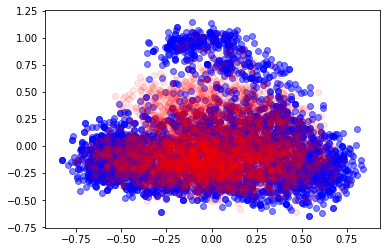

In [0]:
fig, ax = plt.subplots()

x1 = [v[0] for i, v in enumerate(coords) if test_y[i] == 1]
y1 = [v[1] for i, v in enumerate(coords) if test_y[i] == 1]

x2 = [v[0] for i, v in enumerate(coords) if test_y[i] == 0]
y2 = [v[1] for i, v in enumerate(coords) if test_y[i] == 0]

ax.scatter(x1, y1, c="blue", alpha=0.5)
ax.scatter(x2, y2, c="red", alpha=0.1)

plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
sc.fit(train_x)
standard_train_x = sc.transform(train_x)
standard_test_x = sc.transform(test_x)

In [0]:
pca = PCA(n_components=2)
train_x_2d = pca.fit_transform(standard_train_x)
test_x_2d = pca.fit_transform(standard_test_x)

In [0]:
train_x_2d[0:10]

array([[-10.62208063,   8.73129694],
       [-10.37411435,  -0.33640254],
       [ -3.85854072,  27.5544357 ],
       [ -5.65877475,   8.64194934],
       [ -9.35691818,  -5.75393422],
       [ 24.83289608,  -9.26503481],
       [ -0.90823236,   5.41690405],
       [  6.38998436,  -7.7915127 ],
       [ 22.16050929,   2.28581945],
       [  8.37973509,   1.85539583]])

In [0]:
train_x_2d[:, 0].min(), train_x_2d[:, 0].max()

(-24.165124034902917, 27.349558994413517)

In [0]:
test_x_2d[:, 0].min(), test_x_2d[:, 0].max()

(-23.06471202895772, 27.42668878472489)

In [0]:
test_x_2d[:, 1].min(), test_x_2d[:, 1].max()

(-26.03728711372919, 36.795055948544054)

In [0]:
test_x_2d[0:10]

array([[ 3.75143013e+00, -1.04036337e+01],
       [ 1.69700637e+01,  5.66291365e+00],
       [ 3.78326160e+00, -3.10891183e+00],
       [-1.20855727e+01, -6.06467126e-01],
       [-9.50695807e+00,  3.02151595e+01],
       [ 1.58046908e+01,  1.50916591e+00],
       [-1.76218469e+01,  8.93328441e+00],
       [ 1.05737446e+01, -7.11908655e+00],
       [ 9.76951933e+00,  5.15811916e+00],
       [-9.59714252e+00, -2.06913323e-02]])

In [0]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import math

In [0]:
lr = LogisticRegression(C=10)
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='rbf', C=1.0)
dc = DecisionTreeClassifier(criterion='entropy',  max_depth=3)
rf = RandomForestClassifier(criterion='entropy', n_estimators=10)

In [0]:
models = [lr, knn, svm, dc, rf]
model_names = ['logistic regression',
               'k nearest neighbor',
               'svm',
               'decision tree',
               'random forest']

In [0]:
def plot_decision_regions(x, y, model):

    markers = ('s', 'o')
    cmap = ListedColormap(('red', 'blue'))

    x1_min, x1_max = x[:, 0].min()-1, x[:, 0].max()+1
    x2_min, x2_max = x[:, 1].min()-1, x[:, 1].max()+1
    
    resolution = (max(x1_max, x2_max) - min(x1_min, x2_min))/100
    
    x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                   np.arange(x2_min, x2_max, resolution))

    z = model.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
    z = z.reshape(x1_mesh.shape)

    plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap=cmap)
    plt.xlim(x1_mesh.min(), x1_mesh.max())
    plt.ylim(x2_mesh.min(), x2_mesh.max())
        
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=x[y == cl, 0],
                    y=x[y == cl, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolors='black',
                    marker=markers[idx],
                    label=cl)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to 

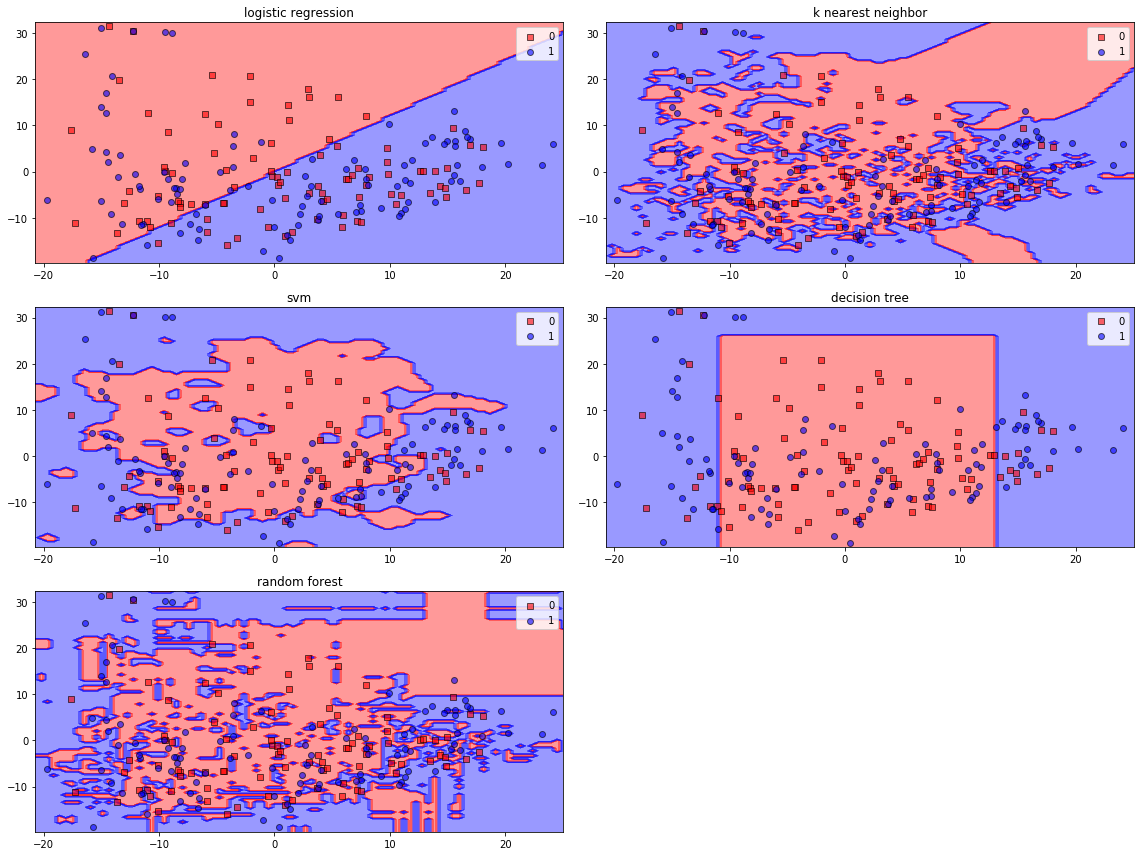

CPU times: user 7.25 s, sys: 953 ms, total: 8.2 s
Wall time: 7.12 s


In [0]:
%%time

plt.figure(figsize=(16,12))
plot_num = 1
for model_name, model in zip(model_names, models):

    plt.subplot(math.ceil(len(models)/2), 2, plot_num)
    
    model.fit(train_x_2d, train_y)    

    plot_decision_regions(test_x_2d[0:200], test_y[0:200], model)
    plt.title(model_name)
    plt.legend()
    plot_num += 1
    

plt.tight_layout()
plt.show()

In [0]:
for model_name, model in zip(model_names, models):
  pred = model.predict(test_x_2d)
  print(model_name + '  accuracy: %.2f' % accuracy_score(test_y, pred))

logistic regression  accuracy: 0.51
k nearest neighbor  accuracy: 0.61
svm  accuracy: 0.64
decision tree  accuracy: 0.63
random forest  accuracy: 0.60


In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()

train_x_1d_lda = lda.fit_transform(standard_train_x, train_y)
test_x_1d_lda = lda.transform(standard_test_x)

In [0]:
train_x_2d_lda = [np.append(v, 0) for v in train_x_1d_lda]
train_x_2d_lda = np.array(train_x_2d_lda).reshape(len(train_x_2d_lda),2)

test_x_2d_lda = [np.append(v, 0) for v in test_x_1d_lda]
test_x_2d_lda = np.array(test_x_2d_lda).reshape(len(test_x_2d_lda),2)


In [0]:
train_x_2d_lda[0:10]

array([[-0.82355941,  0.        ],
       [ 0.5180599 ,  0.        ],
       [-0.80919293,  0.        ],
       [-2.08367383,  0.        ],
       [ 0.0108043 ,  0.        ],
       [ 1.71235555,  0.        ],
       [-0.23409985,  0.        ],
       [ 1.36453947,  0.        ],
       [-1.33370206,  0.        ],
       [ 0.49087765,  0.        ]])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to 

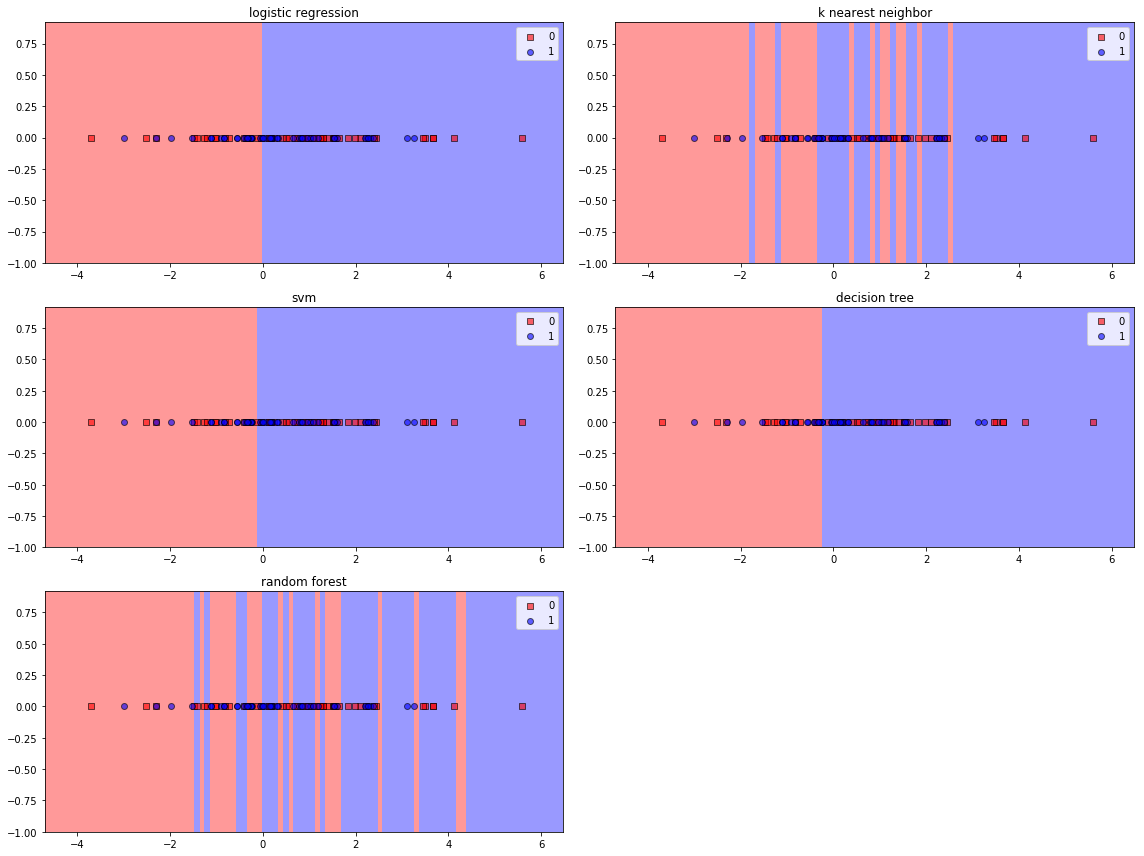

CPU times: user 5.55 s, sys: 876 ms, total: 6.43 s
Wall time: 5.4 s


In [0]:
%%time

plt.figure(figsize=(16,12))
plot_num = 1
for model_name, model in zip(model_names, models):

    plt.subplot(math.ceil(len(models)/2), 2, plot_num)
    
    model.fit(train_x_2d_lda, train_y)
    
    plot_decision_regions(test_x_2d_lda[0:100], test_y[0:100], model)
    plt.title(model_name)
    plt.legend()
    plot_num += 1
    

plt.tight_layout()
plt.show()

In [0]:
for model_name, model in zip(model_names, models):
  pred = model.predict(test_x_2d_lda)
  print(model_name + '  accuracy: %.2f' % accuracy_score(test_y, pred))

logistic regression  accuracy: 0.50
k nearest neighbor  accuracy: 0.50
svm  accuracy: 0.50
decision tree  accuracy: 0.50
random forest  accuracy: 0.50


In [0]:
np.array(train_x).shape, np.array(test_x).shape

((7922, 2048), (7850, 2048))

In [0]:
new_train_x = [v[0:1024]/np.linalg.norm(v[0:1024])-v[1024:2048]/np.linalg.norm(v[1024:2048]) for v in train_x]
new_test_x =  [v[0:1024]/np.linalg.norm(v[0:1024])-v[1024:2048]/np.linalg.norm(v[1024:2048]) for v in test_x]

In [0]:
np.array(new_train_x).shape, np.array(new_test_x).shape

((7922, 1024), (7850, 1024))

In [0]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(new_train_x)
standard_new_train_x = sc.transform(new_train_x)
standard_new_test_x = sc.transform(new_test_x)

In [0]:
pca = PCA(n_components=2)
new_train_x_2d = pca.fit_transform(standard_new_train_x)
new_test_x_2d = pca.fit_transform(standard_new_test_x)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to 

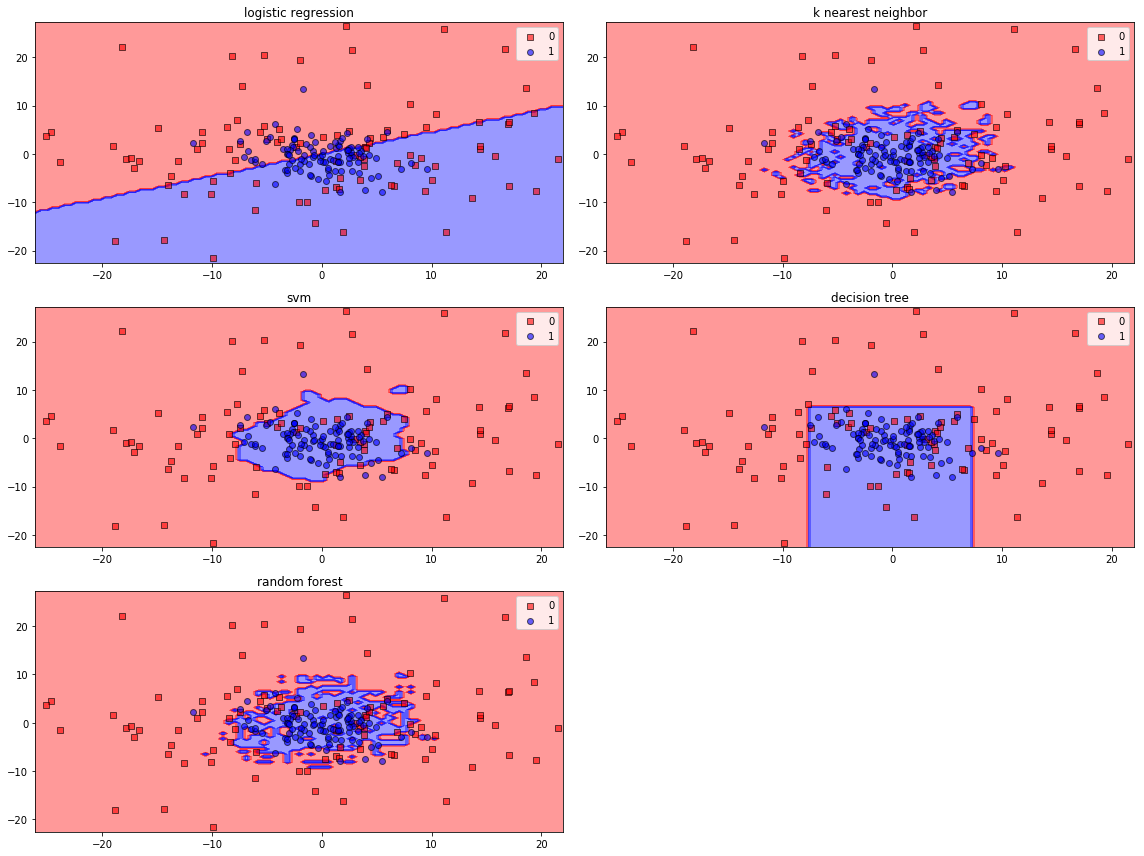

CPU times: user 7.31 s, sys: 941 ms, total: 8.25 s
Wall time: 7.2 s


In [0]:
%%time

plt.figure(figsize=(16,12))
plot_num = 1
for model_name, model in zip(model_names, models):

    plt.subplot(math.ceil(len(models)/2), 2, plot_num)
    
    model.fit(new_train_x_2d, train_y)    

    plot_decision_regions(new_test_x_2d[0:200], test_y[0:200], model)
    plt.title(model_name)
    plt.legend()
    plot_num += 1
    

plt.tight_layout()
plt.show()

In [0]:
for model_name, model in zip(model_names, models):
  model.fit(new_train_x, train_y)    
  pred = model.predict(new_test_x)
  print(model_name + '  accuracy: %.2f' % accuracy_score(test_y, pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logistic regression  accuracy: 0.50
k nearest neighbor  accuracy: 0.69


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


svm  accuracy: 0.58
decision tree  accuracy: 0.73
random forest  accuracy: 0.88


In [0]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 60,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_weight': 2,
    'gamma': 0.2,
    'verbose': 0
}

In [0]:
lgb_train = lgb.Dataset(np.array(new_train_x), np.array(train_y))

In [0]:
%%time

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_train)

[1]	training's binary_logloss: 0.664036
[2]	training's binary_logloss: 0.635041
[3]	training's binary_logloss: 0.608461
[4]	training's binary_logloss: 0.58381
[5]	training's binary_logloss: 0.561114
[6]	training's binary_logloss: 0.539485
[7]	training's binary_logloss: 0.519046
[8]	training's binary_logloss: 0.49971
[9]	training's binary_logloss: 0.481734
[10]	training's binary_logloss: 0.464863
[11]	training's binary_logloss: 0.448826
[12]	training's binary_logloss: 0.433766
[13]	training's binary_logloss: 0.419563
[14]	training's binary_logloss: 0.405866
[15]	training's binary_logloss: 0.39297
[16]	training's binary_logloss: 0.380723
[17]	training's binary_logloss: 0.368982
[18]	training's binary_logloss: 0.357952
[19]	training's binary_logloss: 0.347195
[20]	training's binary_logloss: 0.337283
[21]	training's binary_logloss: 0.327408
[22]	training's binary_logloss: 0.31785
[23]	training's binary_logloss: 0.309069
[24]	training's binary_logloss: 0.300383
[25]	training's binary_loglos

In [0]:
predict_prob = gbm.predict(np.array(new_test_x))

predict_label = [ 1 if elem >= 0.5 else 0 for elem in predict_prob]

acc = sum( np.array(predict_label) == np.array(test_y) ) / len(predict_label)
print("Light GBM accuracy: {}".format(acc))

Light GBM accuracy: 0.9171974522292994


c.f. BERT accuracy: 0.94

In [0]:
models_plus = [lr, knn, svm, dc, rf, lgb]
model_names_plus = ['logistic regression',
               'k nearest neighbor',
               'svm',
               'decision tree',
               'random forest',
               'light gbm']

In [0]:
def plot_decision_regions(x, y, model):

    markers = ('s', 'o')
    cmap = ListedColormap(('red', 'blue'))

    x1_min, x1_max = x[:, 0].min()-1, x[:, 0].max()+1
    x2_min, x2_max = x[:, 1].min()-1, x[:, 1].max()+1
    
    resolution = (max(x1_max, x2_max) - min(x1_min, x2_min))/100
    
    x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                   np.arange(x2_min, x2_max, resolution))

    if model == lgb:
      z = gbm.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
      z = z.reshape(x1_mesh.shape)
    else:
      z = model.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
      z = z.reshape(x1_mesh.shape)

    plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap=cmap)
    plt.xlim(x1_mesh.min(), x1_mesh.max())
    plt.ylim(x2_mesh.min(), x2_mesh.max())
        
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=x[y == cl, 0],
                    y=x[y == cl, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolors='black',
                    marker=markers[idx],
                    label=cl)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to 

[1]	training's binary_logloss: 0.68066
[2]	training's binary_logloss: 0.664318
[3]	training's binary_logloss: 0.653398
[4]	training's binary_logloss: 0.638971
[5]	training's binary_logloss: 0.629415
[6]	training's binary_logloss: 0.616841
[7]	training's binary_logloss: 0.608426
[8]	training's binary_logloss: 0.597219
[9]	training's binary_logloss: 0.589748
[10]	training's binary_logloss: 0.579689
[11]	training's binary_logloss: 0.572927
[12]	training's binary_logloss: 0.56363
[13]	training's binary_logloss: 0.557542
[14]	training's binary_logloss: 0.549118
[15]	training's binary_logloss: 0.543675
[16]	training's binary_logloss: 0.535983
[17]	training's binary_logloss: 0.531027
[18]	training's binary_logloss: 0.524041
[19]	training's binary_logloss: 0.519571
[20]	training's binary_logloss: 0.513239
[21]	training's binary_logloss: 0.509108
[22]	training's binary_logloss: 0.503293
[23]	training's binary_logloss: 0.499531
[24]	training's binary_logloss: 0.494221
[25]	training's binary_logl

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[63]	training's binary_logloss: 0.407018
[64]	training's binary_logloss: 0.405798
[65]	training's binary_logloss: 0.404983
[66]	training's binary_logloss: 0.403824
[67]	training's binary_logloss: 0.403006
[68]	training's binary_logloss: 0.401923
[69]	training's binary_logloss: 0.401169
[70]	training's binary_logloss: 0.400133
[71]	training's binary_logloss: 0.399392
[72]	training's binary_logloss: 0.398407
[73]	training's binary_logloss: 0.397719
[74]	training's binary_logloss: 0.396806
[75]	training's binary_logloss: 0.396172
[76]	training's binary_logloss: 0.395293
[77]	training's binary_logloss: 0.394702
[78]	training's binary_logloss: 0.39389
[79]	training's binary_logloss: 0.393337
[80]	training's binary_logloss: 0.392581


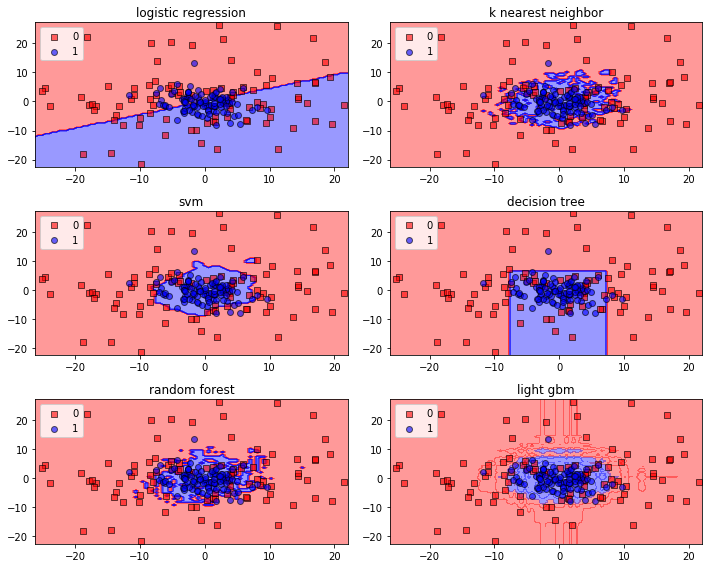

CPU times: user 8.02 s, sys: 970 ms, total: 8.99 s
Wall time: 7.62 s


In [0]:
%%time

plt.figure(figsize=(10,8))
plot_num = 1
for model_name, model in zip(model_names_plus, models_plus):

    plt.subplot(math.ceil(len(models)/2), 2, plot_num)
    
    if model_name == "light gbm":
      lgb_train_2d = lgb.Dataset(np.array(new_train_x_2d), np.array(train_y))
      gbm = model.train(params,
                lgb_train_2d,
                num_boost_round=80,
                valid_sets=lgb_train_2d)
    else:
      model.fit(new_train_x_2d, train_y)    

    plot_decision_regions(new_test_x_2d[0:200], test_y[0:200], model)
    plt.title(model_name)
    plt.legend()
    plot_num += 1
    

plt.tight_layout()
plt.show()

In [0]:
normalized_train_feature = [v/np.linalg.norm(v) for v in train_feature]
normalized_test_feature = [v/np.linalg.norm(v) for v in test_feature]
normalized_grants_feature = [v/np.linalg.norm(v) for v in grants_feature]

In [0]:
np.array(normalized_train_feature).shape, np.array(normalized_test_feature).shape, np.array(normalized_grants_feature).shape,

((3000, 1024), (3000, 1024), (6440, 1024))

In [0]:
import math

def feature_diff(one_app_f, grant_f):
  length = math.ceil(math.log2(len(grant_f)))
  
  for i in range(length):
    one_app_f = np.vstack((one_app_f,one_app_f))
    
  one_app_f = one_app_f[0:len(grant_f)]
  
  one_test_f = one_app_f - grant_f

  return np.array(one_test_f)

In [0]:
test_1 = feature_diff(normalized_test_feature[0], normalized_grants_feature)
np.array(test_1).shape

(6440, 1024)

In [0]:
%%time

predict_prob = []

for v in normalized_test_feature:
  list = []
  list = gbm.predict(feature_diff(v, normalized_grants_feature))
  predict_prob.append(list)

CPU times: user 13min 1s, sys: 18.2 s, total: 13min 20s
Wall time: 8min 52s


In [0]:
np.array(predict_prob).shape

(3000, 6440)

In [0]:
citations = citations_info[citations_info["action_type"] == 102]
cite_app = citations["app_id"]
cite_grant = citations ["parsed"]
cite_relation = pd.concat([cite_app, cite_grant], axis=1)

In [0]:
def test_label(app_id, grants, cite_relation):
  cited_parsed = cite_relation[cite_relation["app_id"] == app_id]["parsed"]
  return [ 1 if parsed == cited_parsed.values[0] else 0 for parsed in grants["parsed"] ]

In [0]:
labels = [test_label(app_id, grants, cite_relation)  for app_id in testset_app_3000["app_id"]]

In [0]:
%%time

ranking = []

for num in range(len(predict_prob)):

  app_id = testset_app_3000['app_id'][num]
  label = pd.Series(test_label(app_id, grants, cite_relation))
    
  i, = np.where(label == 1)
  cited_index = i[0]
  rank = sorted(predict_prob[num], reverse=True).index(predict_prob[num][cited_index])
  ranking.append(rank)

CPU times: user 43 s, sys: 12.5 ms, total: 43 s
Wall time: 43 s


In [0]:
%%time

ranking_arr = np.array(ranking)

positive_counts = [sum(ranking_arr <= thrd) for thrd in range(len(grants))]

CPU times: user 41.9 s, sys: 9.86 ms, total: 41.9 s
Wall time: 42 s


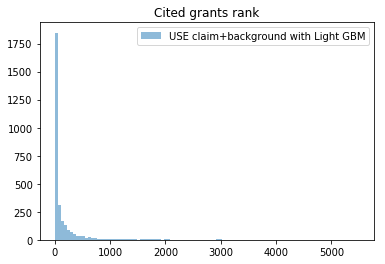

In [0]:
import matplotlib.pyplot as plt

plt.hist(ranking, alpha=0.5, bins=100, label="USE claim+background with Light GBM")
plt.title("Cited grants rank")
plt.legend()
plt.show()

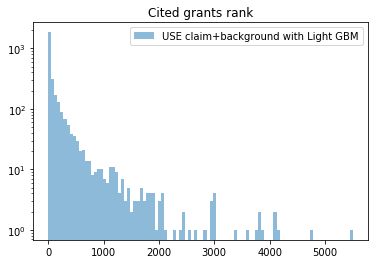

In [0]:
import matplotlib.pyplot as plt

plt.hist(ranking, alpha=0.5, bins=100, label="USE claim+background with Light GBM")
plt.yscale('log')
plt.title("Cited grants rank")
plt.legend()
plt.show()

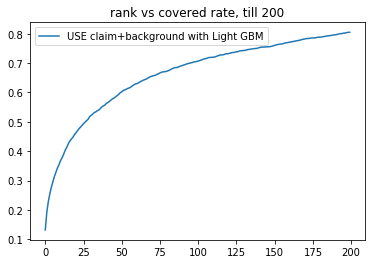

In [0]:
plt.plot(range(200), (np.array(positive_counts)/len(ranking))[0:200], label="USE claim+background with Light GBM")
plt.title("rank vs covered rate, till 200")
plt.legend()
plt.show()

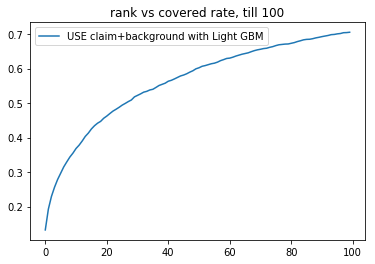

In [0]:
plt.plot(range(100), (np.array(positive_counts)/len(ranking))[0:100], label="USE claim+background with Light GBM")
plt.title("rank vs covered rate, till 100")
plt.legend()
plt.show()

In [0]:
 (np.array(positive_counts)/len(ranking))[100],  (np.array(positive_counts)/len(ranking))[200]

(0.7066666666666667, 0.806)

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()

train_x_1d_lda = lda.fit_transform(new_train_x, train_y)
test_x_1d_lda = lda.transform(new_test_x)

In [0]:
train_x_2d_lda = [np.append(v, 0) for v in train_x_1d_lda]
train_x_2d_lda = np.array(train_x_2d_lda).reshape(len(train_x_2d_lda),2)

test_x_2d_lda = [np.append(v, 0) for v in test_x_1d_lda]
test_x_2d_lda = np.array(test_x_2d_lda).reshape(len(test_x_2d_lda),2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to 

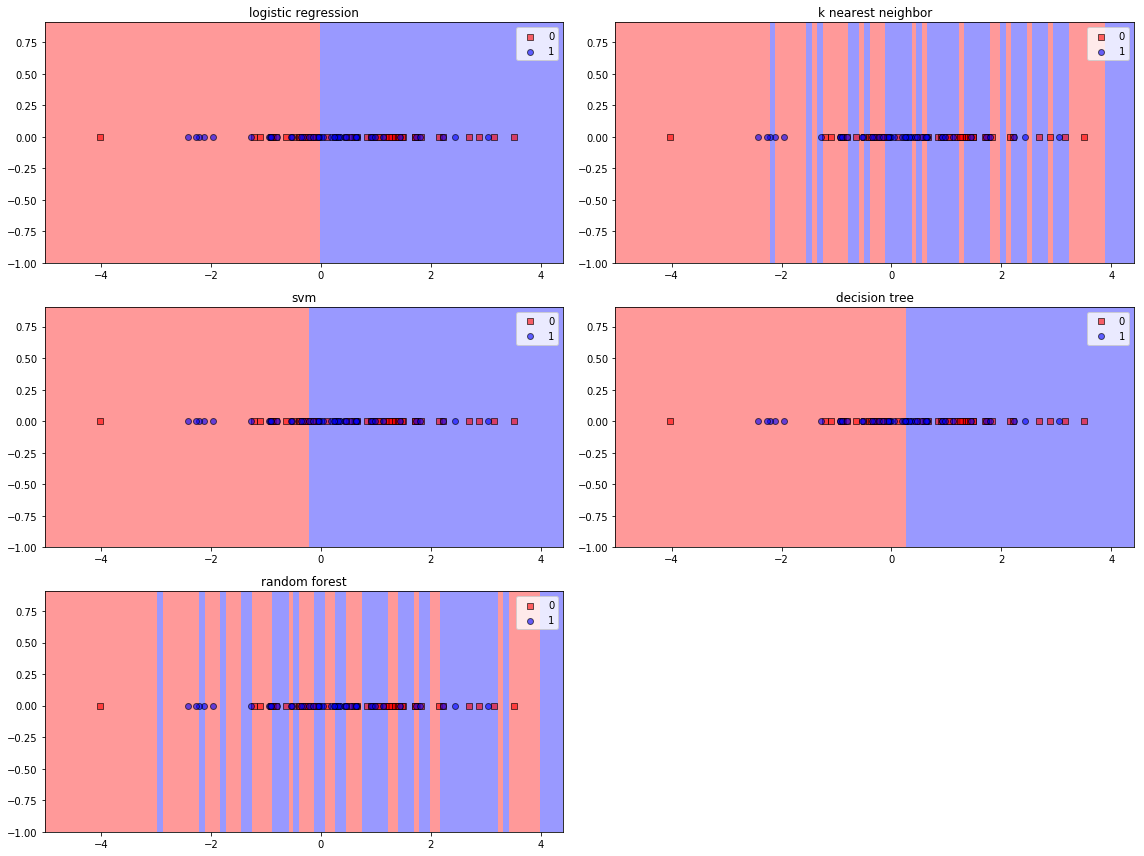

CPU times: user 5.71 s, sys: 859 ms, total: 6.57 s
Wall time: 5.53 s


In [0]:
%%time

plt.figure(figsize=(16,12))
plot_num = 1
for model_name, model in zip(model_names, models):

    plt.subplot(math.ceil(len(models)/2), 2, plot_num)
    
    model.fit(train_x_2d_lda, train_y)
    
    plot_decision_regions(test_x_2d_lda[0:100], test_y[0:100], model)
    plt.title(model_name)
    plt.legend()
    plot_num += 1
    

plt.tight_layout()
plt.show()

In [0]:
norm_train_x = [np.linalg.norm(v) for v in new_train_x]

In [0]:
norm_train_x[0:10]

[1.0143959725803493,
 0.9160518314995092,
 0.5988716299896668,
 1.1058311758035166,
 0.8945745675385175,
 0.703500182102844,
 0.693230131594738,
 0.8042198483723632,
 0.8711187128026817,
 1.0126155009156104]

In [0]:
train_y[0:10]

[0, 0, 1, 0, 0, 1, 1, 0, 1, 0]

In [0]:
norm_test_x = [np.linalg.norm(v) for v in new_test_x]

In [0]:
norm_train_x = [np.append(v, 0) for v in norm_train_x]
norm_train_x = np.array(norm_train_x).reshape(len(norm_train_x),2)

norm_test_x = [np.append(v, 0) for v in norm_test_x]
norm_test_x = np.array(norm_test_x).reshape(len(norm_test_x),2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to 

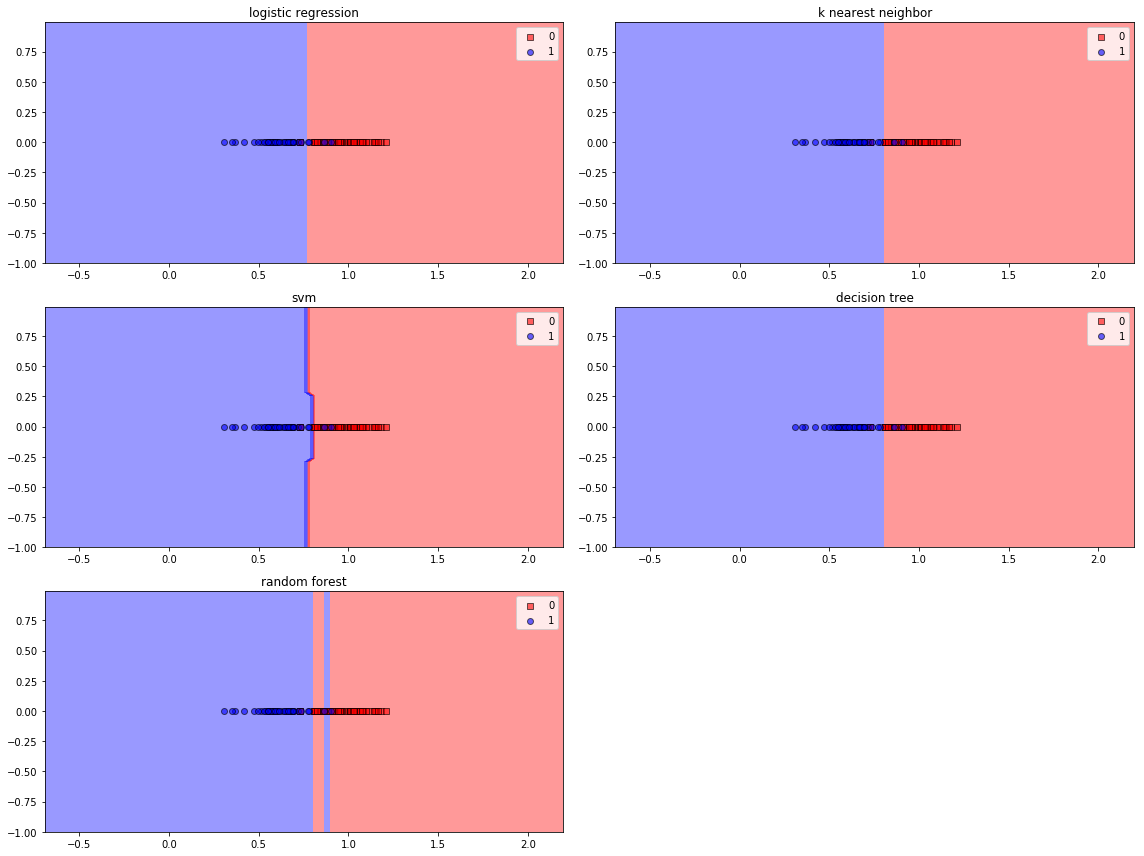

CPU times: user 3.53 s, sys: 857 ms, total: 4.38 s
Wall time: 3.34 s


In [0]:
%%time

plt.figure(figsize=(16,12))
plot_num = 1
for model_name, model in zip(model_names, models):

    plt.subplot(math.ceil(len(models)/2), 2, plot_num)
    
    model.fit(norm_train_x, train_y)
    
    plot_decision_regions(norm_test_x[0:100], test_y[0:100], model)
    plt.title(model_name)
    plt.legend()
    plot_num += 1
    

plt.tight_layout()
plt.show()

#t-SNE

In [0]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(train_x)
standard_train_x = sc.transform(train_x)
standard_test_x = sc.transform(test_x)

In [0]:
%%time

from sklearn.manifold import TSNE

tsne_train_x = TSNE(n_components=2, random_state=0).fit_transform(standard_train_x)
tsne_test_x = TSNE(n_components=2, random_state=0).fit_transform(standard_test_x)

CPU times: user 15min 35s, sys: 911 ms, total: 15min 36s
Wall time: 15min 36s


In [0]:
tsne_train_x.shape, tsne_test_x.shape

((7922, 2), (7850, 2))

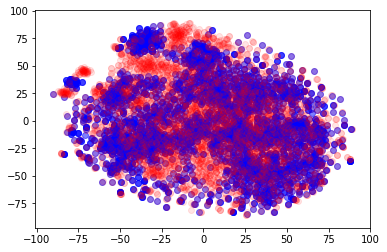

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x1 = [v[0] for i, v in enumerate(tsne_train_x) if train_y[i] == 1]
y1 = [v[1] for i, v in enumerate(tsne_train_x) if train_y[i] == 1]

x2 = [v[0] for i, v in enumerate(tsne_train_x) if train_y[i] == 0]
y2 = [v[1] for i, v in enumerate(tsne_train_x) if train_y[i] == 0]

ax.scatter(x1, y1, c="blue", alpha=0.5)
ax.scatter(x2, y2, c="red", alpha=0.1)

plt.show()

In [0]:
new_train_x = [v[0:1024]/np.linalg.norm(v[0:1024])-v[1024:2048]/np.linalg.norm(v[1024:2048]) for v in train_x]
new_test_x =  [v[0:1024]/np.linalg.norm(v[0:1024])-v[1024:2048]/np.linalg.norm(v[1024:2048]) for v in test_x]

In [0]:
%%time

from sklearn.manifold import TSNE

sc = StandardScaler()
sc.fit(new_train_x)
standard_new_train_x = sc.transform(new_train_x)
standard_new_test_x = sc.transform(new_test_x)

tsne_new_train_x = TSNE(n_components=2, random_state=0).fit_transform(standard_new_train_x)
tsne_new_test_x = TSNE(n_components=2, random_state=0).fit_transform(standard_new_test_x)

CPU times: user 10min 10s, sys: 769 ms, total: 10min 11s
Wall time: 10min 11s


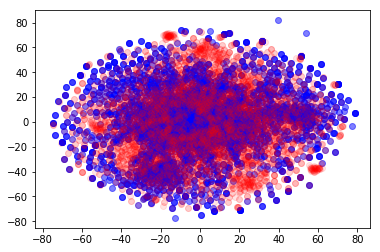

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x1 = [v[0] for i, v in enumerate(tsne_new_train_x) if train_y[i] == 1]
y1 = [v[1] for i, v in enumerate(tsne_new_train_x) if train_y[i] == 1]

x2 = [v[0] for i, v in enumerate(tsne_new_train_x) if train_y[i] == 0]
y2 = [v[1] for i, v in enumerate(tsne_new_train_x) if train_y[i] == 0]

ax.scatter(x1, y1, c="blue", alpha=0.5)
ax.scatter(x2, y2, c="red", alpha=0.1)

plt.show()

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x1 = [v[0] for i, v in enumerate(tsne_new_train_x) if train_y[i] == 1]
y1 = [v[1] for i, v in enumerate(tsne_new_train_x) if train_y[i] == 1]

x2 = [v[0] for i, v in enumerate(tsne_new_train_x) if train_y[i] == 0]
y2 = [v[1] for i, v in enumerate(tsne_new_train_x) if train_y[i] == 0]

ax.scatter(x1, y1, c="blue", alpha=0.5)
ax.scatter(x2, y2, c="red", alpha=0.1)

plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
sc.fit(new_train_x)
standard_new_train_x = sc.transform(new_train_x)
standard_new_test_x = sc.transform(new_test_x)

pca = PCA(n_components=2)
new_train_x_2d = pca.fit_transform(standard_new_train_x)
new_test_x_2d = pca.fit_transform(standard_new_test_x)

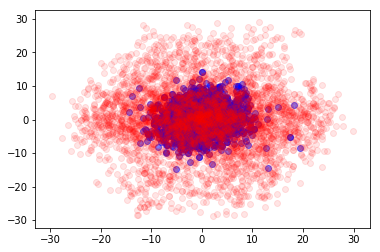

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x1 = [v[0] for i, v in enumerate(new_train_x_2d) if train_y[i] == 1]
y1 = [v[1] for i, v in enumerate(new_train_x_2d) if train_y[i] == 1]

x2 = [v[0] for i, v in enumerate(new_train_x_2d) if train_y[i] == 0]
y2 = [v[1] for i, v in enumerate(new_train_x_2d) if train_y[i] == 0]

ax.scatter(x1, y1, c="blue", alpha=0.5)
ax.scatter(x2, y2, c="red", alpha=0.1)

plt.show()